# Gridding missed locations

In previous file, there seems to be large empty spaces on the map that were likely missed in the previous place matching code. Explore why these matches were missed and add these into the previous dataset.

In [118]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colormaps
import matplotlib as mpl
import warnings
from shapely.geometry import Polygon
import shapely.wkt

import shapely.vectorized
from global_land_mask import globe
import os
import time
import numpy as np
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import geopandas
from matplotlib import colormaps

# Investigate potential solution through missing match to Indian Ocean

In the 02_Gridding-locations.ipynb file, barely any articles were identified in the indian ocean -- double check why this is and potential fixes that can be applied to the whole dataset.

In [109]:
shp_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/shp_df_natural-earth-shapes.csv')

/tmp/ipykernel_271193/3971884773.py:1: DtypeWarning: Columns (3,4,7,9,10,12,13,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,41,42,43,44,45,46,47,51,52,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,169,171,172,173,176,177,178,179,180,181,183,184,185,190,191,198,199,201,202,205,206,208,209,210,212,214,217,218,219,221,222,223,255,256,257,259,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  shp_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/shp_df_natural-earth-shapes.csv')


In [47]:
# subset to locations in the indian ocean
indOceanShps = shp_df[shp_df["name_en"].str.contains("Indian Ocean", case=False)==True]

#indOceanShpsInd = shp_df.apply(lambda col: col.str.contains("Indian Ocean", na=False), axis=1)

indOceanShps.loc[:,["name", 'geometry', 'shpfile_id']].head()

,name,geometry,shpfile_id
2795,Iles Eparses de l'ocean Indien,MULTIPOLYGON (((42.75180097700007 -17.07610442...,2795
3148,British Indian Ocean Territory,MULTIPOLYGON (((72.46753991000008 -7.383884372...,3148
5890,INDIAN OCEAN,POLYGON ((166.0663806500879 -60.53346241642453...,5890


INDIAN OCEAN
str
Polygon


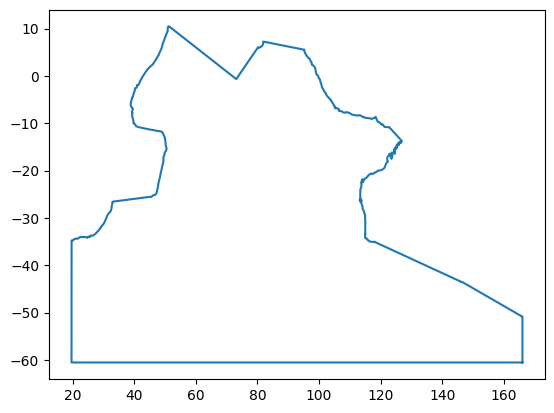

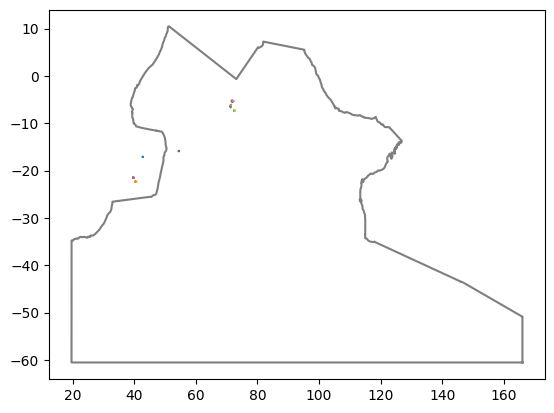

In [95]:
# quick plot of Indian Ocean polygons

# Plot just the indian Ocean
print(indOceanShps.name.iloc[2])
p = indOceanShps.geometry.iloc[2]
print(type(p).__name__)
P = shapely.wkt.loads(p)
print(type(P).__name__)
plt.plot(*P.exterior.xy)

# Plot all polygons in the indian ocean
fig, axs = plt.subplots()
for i, place in indOceanShps.iterrows():
    p = place.geometry
    P = shapely.wkt.loads(p)
    
    if type(P).__name__ == "MultiPolygon":
        for geom in P.geoms:    
            plt.plot(*geom.exterior.xy)
            
    else:
        plt.plot(*P.exterior.xy)

plt.show()


In [82]:
# So there is a place for INDIAN OCEAN (shpfile_id = 5890) but it is not getting recognized? Check
# check it is getting gridded -- no it is not!

shp_grid_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/shp_grid_df.csv')
indOcean_shp_grid_df = shp_grid_df[shp_grid_df["shpfile_id"]==5890]

list(indOcean_shp_grid_df.columns)
indOcean_shp_grid_df.shape
print(indOcean_shp_grid_df)

Empty DataFrame
Columns: [shpfile_id, grid_df_id]
Index: []


In [103]:
# Explore how to identify grid cells for the just the Indian Ocean

import shapely.vectorized

# Regrid for just this shpfile_id
## Match shapefiles to gridcell indices 
gridRes = 2.5
grid_df = pd.read_csv(f'/home/dveytia/test-mordecai/outputs/grid_df_res{gridRes}.csv', low_memory=False) # the grid

# We are going to store our shapefile-gridcell index matches here
shp_grid = []

# This is the grid we will work with
yv, xv = np.meshgrid(grid_df.LAT.unique(), grid_df.LON.unique())

place = indOceanShps[indOceanShps.shpfile_id == 5890] # get the row of the dataset corresponding to the indian ocean
#print(place.name)
#print(place.geometry)
p = place.geometry.iloc[0]

#p = indOceanShps.geometry.iloc[2]
#print(type(p).__name__)
P = shapely.wkt.loads(p) ## THIS was the missing puzzle peice
print(type(P).__name__)


inplace = shapely.vectorized.contains(P, xv, yv) # find which gridcells are contained
idx = np.argwhere(inplace)
number_cells = idx.size/2

for point in idx:
    lon = grid_df.LON.unique()[point[0]]
    lat = grid_df.LAT.unique()[point[1]]
    da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
    shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]}) 

shp_grid_df = pd.DataFrame.from_dict(shp_grid)
    
print(shp_grid_df.shape) # now there are grid cells found matching!
shp_grid_df.head(2)


Polygon
(979, 2)


,shpfile_id,grid_df_id
0,5890,1808
1,5890,1952


# Apply fix to all shapefiles as other shapes could also have missing grid cell matches

In [111]:
## REPEAT MATCHING SHAPEFILES TO GRID FOR ALL PLACE IDS
## Match shapefiles to gridcell indices 

# We are going to store our shapefile-gridcell index matches here
shp_grid = []

# This is the grid we will work with
yv, xv = np.meshgrid(grid_df.LAT.unique(), grid_df.LON.unique())
for i, place in shp_df.iterrows(): # Now we go through all the shapes
    # show which gridcell centers are contained inside the shape
    # ignore the warning caused by shapely using an old version of numpy
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = place.geometry
        P = shapely.wkt.loads(p)
        inplace = shapely.vectorized.contains(P, xv, yv)
    idx = np.argwhere(inplace)
    # Get the number of cells contained in the shape
    number_cells = idx.size/2
    if number_cells == 0:
        # If we have no cell centers in the shape, get the shape center and the cell which contains it
        c = P.centroid
        lon = c.x//gridRes*gridRes+gridRes*0.5
        lat = c.y//gridRes*gridRes+gridRes*0.5
        da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
        shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]})
    else:
        for point in idx:
            lon = grid_df.LON.unique()[point[0]]
            lat = grid_df.LAT.unique()[point[1]]
            da_df = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)]
            shp_grid.append({"shpfile_id": i, "grid_df_id": da_df.index[0]}) 

shp_grid_df2 = pd.DataFrame.from_dict(shp_grid)
    

shp_grid_df2.head(2)

,shpfile_id,grid_df_id
0,0,4114
1,0,3971


In [112]:
## Check that new shp_grid_df2 has cells for the indian ocean -- yes!!!
indOcean_shp_grid_df2 = shp_grid_df2[shp_grid_df2["shpfile_id"]==5890]

indOcean_shp_grid_df2.shape
print(indOcean_shp_grid_df2)

       shpfile_id  grid_df_id
24970        5890        1808
24971        5890        1952
24972        5890        2096
24973        5890        2240
24974        5890        2384
...           ...         ...
25944        5890        2296
25945        5890        1865
25946        5890        2009
25947        5890        2153
25948        5890        2297

[979 rows x 2 columns]


In [113]:
## Write new file
shp_grid_df2.to_csv(f'/home/dveytia/test-mordecai/outputs/shp_grid_df2.csv',index=False)

# Repeat document to grid matching with new shp_grid_df

Look for place matches between mordecai geoparsing results and the shape files, and then map these results to grid cells. Then sum the number of documents found in each grid cell

In [119]:
## Load in geoparsed location data

# Set the directory path where your CSV files are located
directory_path = '/home/dveytia/test-mordecai/outputs/geoparsed-text'
dfs = [] # initialise empty list

# Loop through all files in the directory and load
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        # Read each CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames in the list into one
places = pd.concat(dfs, ignore_index=True)
places = places.drop_duplicates(["id","geonameid"]) 
places = places.rename(columns={"id": "analysis_id"})
print(places.shape)
places.head(2)

(44127, 15)


,analysis_id,duplicate_id,title,word,spans,country_predicted,country_conf,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,369746,1997.4164,Study on multi-function ocean thermal energy c...,Fiji,"[{'start': 783, 'end': 787}]",FJI,0.946707,NaN,-18.0000,178.000,FJI,2205218,Republic of Fiji,A,PCLI
1,369760,1997.4175,Role of sewage phosphorus in coastal water ene...,Tuticorin,"[{'start': 133, 'end': 142}]",IND,0.952811,Tamil Nadu,8.8375,77.963,IND,7627069,Thoothukkudi,A,ADM2


In [120]:
feature_mapping = {
    "ADM1": ["Admin-1 scale rank", "Admin-1 aggregation", "Admin-1 minor island"],
    "PCLI": ["Admin-0 country"],
    'MTS': ['Range/mtn'],
    'PLAT': ['Plateau'],
    'PLN': ['Plain'],
    'DSRT': ['Desert'],
    'OCN': ['ocean'],
    'SEA': ['sea', 'bay'],
    'GULF': ['gulf', 'bay'],
    'BAY': ['gulf', 'bay'],
    'CHN': ['channel'],
    'BSNU': ['basin']
}

In [121]:
# We add all the other codes we don't cover with blank shapefile classes
for fcode in places.feature_code.unique():
    if fcode not in feature_mapping:
        feature_mapping[fcode] = []

In [122]:
# To help match, we will rename some shapes so that they are the same as the name in our database
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Altay", case=False)),"name"] = "Altay"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Appalach", case=False)),"name"] = "Appalachian Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("cant", case=False)),"name"] = "Cordillera Cantábrica"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Dabie", case=False)),"name"] = "Dabie Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("EASTERN GHATS", case=False)),"name"] = "Eastern Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("WESTERN GHATS", case=False)),"name"] = "Western Ghāts"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("kunlun", case=False)),"name"] = "Kalakunlun Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("LEN MOUNTAIN", case=False)),"name"] = "Kölen"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Taihang Mts.", case=False)),"name"] = "Taihang Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Tatra Mts.", case=False)),"name"] = "Tatry"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("TIAN SHAN", case=False)),"name"] = "Tien Shan"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("andes", case=False)),"name"] = "Andes Mountains"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("HINDU KUSH", case=False)),"name"] = "Hindū Kush"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Marrah Mts", case=False)),"name"] = "Jabal Marrah"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("Lebanon", case=False)),"name"] = "Mount Lebanon"
shp_df.loc[(shp_df["featurecla"]=="Range/mtn") & (shp_df["name"].str.contains("KARAKORAM RA", case=False)),"name"] = "Karakorum Shan"

shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Negev", case=False)), "name"] = "Negev"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Atacama", case=False)), "name"] = "Atacama Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("CHIHUAHUAN DESERT", case=False)), "name"] = "Chihuahua Desert"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("Lut desert", case=False)), "name"] = "God-e Lut"
shp_df.loc[(shp_df["featurecla"]=="Desert") & (shp_df["name"].str.contains("TAKLIMAKAN DESERT", case=False)), "name"] = "Takla Makan Desert"

shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("cumberland", case=False)),["name","featurecla"]
] = ["Cumberland Plateau", "Plain"]
shp_df.loc[
    (shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("colorado", case=False)),["name","featurecla"]
] = ["San Francisco Plateau", "Plain"]
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("gange", case=False)),"name"] = "Gangetic Plain"
shp_df.loc[(shp_df["featurecla"]=="Plain") & (shp_df["name"].str.contains("north china", case=False)),"name"] = "Huanghuai Pingyuan"

shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("mongol", case=False)), "name"] = "Nei Mongol Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("deccan", case=False)), "name"] = "Deccan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("chota", case=False)), "name"] = "Chota Nāgpur Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("loess", case=False)), "name"] = "Huangtu Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("khorat", case=False)), "name"] = "Khorat Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("tibet", case=False)), "name"] = "Qing Zang Gaoyuan"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("polar", case=False)), "name"] = "South Polar Plateau"
shp_df.loc[(shp_df["featurecla"]=="Plateau") & (shp_df["name"].str.contains("YUNGUI", case=False)), "name"] = "Yungui Gaoyuan"

places["place_name"] = places["place_name"].str.lower().str.replace("mts.","mountains") 
shp_df["name"] = shp_df["name"].str.lower().str.replace("mts.","mountains") 

/tmp/ipykernel_271193/2263670162.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  places["place_name"] = places["place_name"].str.lower().str.replace("mts.","mountains")
/tmp/ipykernel_271193/2263670162.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  shp_df["name"] = shp_df["name"].str.lower().str.replace("mts.","mountains")


In [123]:
## NB this takes several min to run
## For each document that has a place, search for a match from the natural earth shapefiles and it's corresponding grid cell indexes
## Reminder the object 'places' is a data frame that contains all the document information with places identified

# We'll start off with an empty dataframe
shp_df_matches2 = pd.DataFrame()

# Now we want to look through the feature type dictionary we had before
for place_key, shpfile_keys in feature_mapping.items():
    
    #print(place_key)
    
    # We can get all the places and all the shapes
    feature_places = places.loc[places["feature_code"]==place_key]
    feature_shapes = shp_df.loc[shp_df["featurecla"].isin(shpfile_keys)]
    
    # And loop through the places
    for place, group in feature_places.groupby("place_name"):
        # If we don't have a shapefile feature type we just take the grid cell containing the point
        if not shpfile_keys:
            shp_id = None # we set shp_id to None, round the coordinates, and take the gridcell which has these coordinates
            lon = group.lon.values[0]//gridRes*gridRes+gridRes*0.5
            lat = group.lat.values[0]//gridRes*gridRes+gridRes*0.5
            grid_df_ids = grid_df[(grid_df['LON']==lon) & (grid_df['LAT']==lat)].index

        else:
            # Otherwise, we are going to try to find the places which match
            place_shapes = pd.DataFrame()
            # First we will try by geoname ids, if we have these
            if feature_shapes["gn_id"].sum() > 0:
                place_shapes = feature_shapes.loc[
                    (feature_shapes["gn_id"]==group.geonameid.values[0])
                ]
            # Then we try by country code, if we are dealing with a country
            if place_shapes.shape[0]==0 and place_key=="PCLI":
                place_shapes = feature_shapes.loc[
                    feature_shapes["ADM0_A3"] == group.country_predicted.values[0]
                ]
            # Then we try by name
            if place_shapes.shape[0]==0:       
                place_shapes = feature_shapes.loc[
                    (feature_shapes.name == place)
                ]    

            if place_shapes.shape[0]==0:
                continue # These are the places we cannot match, we need to develop other strategies for these, e.g. using other shapefile libraries
    #            if key=="ADM1": # can also try using gadm data, which we need to download separately
    #                 place_shapes = adm1shps_alt[
    #                     (adm1shps_alt["NAME_1"]==group.place_name.values[0]) |
    #                     (adm1shps_alt["VARNAME_1"].str.contains(group.place_name.values[0]))
    #                 ]
            else:
                shp_id = place_shapes.index[0]
                grid_df_ids = shp_grid_df2.loc[
                    (shp_grid_df2["shpfile_id"]==shp_id),
                    "grid_df_id"
                ]
        # For each document with this place, we add a row for each grid cell index matching the place
        for did in group.analysis_id.unique():
            shp_df_matches2 = pd.concat([
                shp_df_matches2,
                pd.DataFrame.from_dict({
                    "grid_df_id": grid_df_ids,
                    "analysis_id": [did] * len(grid_df_ids),
                    "shp_id": [shp_id] * len(grid_df_ids),
                    "place": place
                })
            ])
            
            
print(shp_df_matches2.shape)
shp_df_matches2.head(2)


(860456, 4)


,grid_df_id,analysis_id,shp_id,place
2488,6095,284452.0,232,antigua and barbuda
2488,6095,358945.0,232,antigua and barbuda


In [133]:
# buttt there are some rows missing that were found in the previous form of the script, so merge together.
shp_df_matches = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_shp_df_matches.csv", low_memory = False)
shp_df_matches3 = pd.concat([shp_df_matches[['grid_df_id', "analysis_id","shp_id","place"]], shp_df_matches2[['grid_df_id', "analysis_id","shp_id","place"]]]).drop_duplicates()
print(shp_df_matches3.shape)
shp_df_matches3.head(2)

(1238509, 4)


,grid_df_id,analysis_id,shp_id,place
0,6095,284452.0,232.0,antigua and barbuda
1,7568,284452.0,232.0,antigua and barbuda


In [141]:
## For each unique document and place, calculate the 1/the number of grid cells occupied by that place to get the grid cell weight
shp_df_weight = shp_df_matches3.groupby(['analysis_id','shp_id']).apply(lambda x: 1/len(x)).reset_index() # calculate 1/number of grid cells per place
shp_df_weight = shp_df_weight.set_axis(['analysis_id','shp_id','cell_weight'], axis=1) # rename columns
shp_df_matches3 = shp_df_matches3.merge(shp_df_weight, how='left') # Merge back into the corresponding grid cells


print(shp_df_matches3.shape)
shp_df_matches3.head(2)


## Do for version 2 as well
shp_df_weight = shp_df_matches2.groupby(['analysis_id','shp_id']).apply(lambda x: 1/len(x)).reset_index() # calculate 1/number of grid cells per place
shp_df_weight = shp_df_weight.set_axis(['analysis_id','shp_id','cell_weight'], axis=1) # rename columns
shp_df_matches2 = shp_df_matches2.merge(shp_df_weight, how='left') # Merge back into the corresponding grid cells


print(shp_df_matches2.shape)
shp_df_matches2.head(2)

(1238509, 5)
(860456, 5)


,grid_df_id,analysis_id,shp_id,place,cell_weight
0,6095,284452.0,232.0,antigua and barbuda,1.0
1,6095,358945.0,232.0,antigua and barbuda,1.0


In [135]:
## Write to csv
shp_df_matches2.to_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_shp_df_matches2.csv",index=False)
shp_df_matches3.to_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_shp_df_matches3.csv",index=False)

# Read in document to shpfile matches and sum number of matches per cell

In [138]:
## Read in 
shp_df_matches3 = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_shp_df_matches3.csv", low_memory = False)

## For each grid cell, sum the number of documents 
shp_df_sum = shp_df_matches3.groupby(['grid_df_id']).apply(lambda x: len(x)).reset_index()
shp_df_sum = shp_df_sum.set_axis(['grid_df_id','n_articles'], axis=1)

## For each grid cell, sum the weighted number of documents to get the weighted sum
shp_df_weightedSum = shp_df_matches3.groupby(['grid_df_id'])['cell_weight'].sum().reset_index()
shp_df_weightedSum = shp_df_weightedSum.set_axis(['grid_df_id','n_articles_weighted'], axis=1)


## Merge all together with the grid cell locations 
# Format the grid so the id column is identiical to allow for a merge
grid_df3 = grid_df
grid_df3['grid_df_id'] = grid_df.index

# Merge
shp_df_sum_grid3 = grid_df3.merge(shp_df_sum, how = "left")
shp_df_sum_grid3 = shp_df_sum_grid3.merge(shp_df_weightedSum, how = "left")

# Summarise
shp_df_sum_grid3['n_articles'] = shp_df_sum_grid3['n_articles'].fillna(0) # set NAs to 0
shp_df_sum_grid3['n_articles_weighted'] = shp_df_sum_grid3['n_articles_weighted'].fillna(0) # set NAs to 0
print(shp_df_sum_grid3.shape)
print(shp_df_sum_grid3.describe())
print(shp_df_sum_grid3.head())



(10368, 7)
                LAT           LON   grid_df_id       area_km    n_articles  \
count  10368.000000  10368.000000  10368.00000  10368.000000  10368.000000   
mean       0.000000      0.000000   5183.50000  49196.033170    119.454958   
std       51.959018    103.925555   2993.12813  23773.819701    199.682932   
min      -88.750000   -178.750000      0.00000   1685.654015      0.000000   
25%      -44.375000    -89.375000   2591.75000  30341.895615      1.000000   
50%        0.000000      0.000000   5183.50000  54625.716973     46.000000   
75%       44.375000     89.375000   7775.25000  71049.402794    192.000000   
max       88.750000    178.750000  10367.00000  77252.429797   2637.000000   

       n_articles_weighted  
count         10368.000000  
mean              1.509838  
std               9.297283  
min               0.000000  
25%               0.009322  
50%               0.082681  
75%               0.229295  
max             295.271429  
     LAT     LON  grid_df

In [139]:
# Save
shp_df_sum_grid3.to_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums3.csv",index=False)

## Simple map to visualize

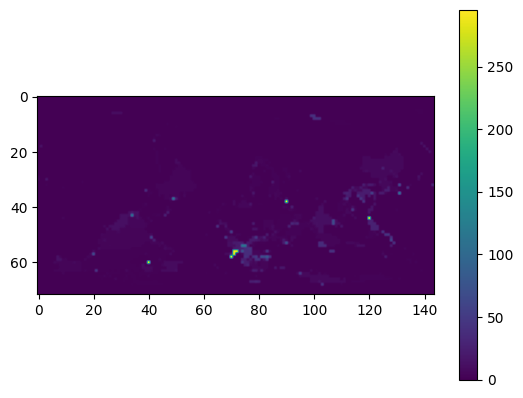

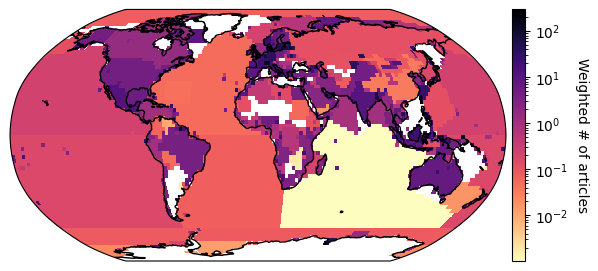

In [140]:
## Plot of all articles using the weighted sum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colormaps
import matplotlib as mpl
    
# Read in the data    
shp_df_sum_grid3 = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums3.csv")
gridlons = shp_df_sum_grid3.LON.unique()
gridlats = shp_df_sum_grid3.LAT.unique()
shape = (len(gridlats), len(gridlons))
n = np.array(shp_df_sum_grid3.n_articles_weighted).reshape(shape)


# set up a map
fig=plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# Can use the regular grid lons and lats with the shading ='nearest' option
im = plt.pcolormesh(gridlons, gridlats, n, shading = 'nearest',
              cmap=colormaps['magma_r'], norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree()) 

ax.coastlines()

## Colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Weighted # of articles', rotation=270)

# Save
plt.savefig(f'/home/dveytia/test-mordecai/figures/geoparsed-text-map3.pdf',bbox_inches="tight") # Save plot, change file path and name
plt.show()


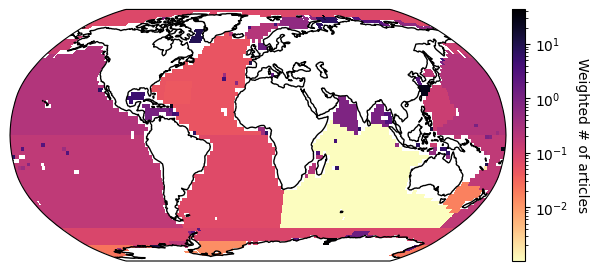

In [142]:
## Plot of all articles in the ocean only using the weighted sum

# Read in the data    
shp_df_sum_grid3 = pd.read_csv("/home/dveytia/test-mordecai/outputs/geoparsed-text_grid-sums3.csv")

# Set everything on land to 0
shp_df_sum_grid_ocean = shp_df_sum_grid3
shp_df_sum_grid_ocean.loc[shp_df_sum_grid_ocean['is_land'] == True, 'n_articles_weighted'] = 0

# Format into grid
gridlons = shp_df_sum_grid_ocean.LON.unique()
gridlats = shp_df_sum_grid_ocean.LAT.unique()
shape = (len(gridlats), len(gridlons))
n = np.array(shp_df_sum_grid_ocean.n_articles_weighted).reshape(shape)

# set up a map
fig=plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# Can use the regular grid lons and lats with the shading ='nearest' option
im = plt.pcolormesh(gridlons, gridlats, n, shading = 'nearest',
              cmap=colormaps['magma_r'], norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree()) 

ax.coastlines()

## Colourbar
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Weighted # of articles', rotation=270)

# Save
plt.savefig(f'/home/dveytia/test-mordecai/figures/geoparsed-text-ocean-map3.pdf',bbox_inches="tight") # Save plot, change file path and name
plt.show()